In [1]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel
from ntwrk.bayesopt import Surrogate, BayesOpt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def true_func(x, noise=0.1):
    return 0.6 * torch.sin(3 * (x-1.)) + torch.sin(1.2 * x) + noise * torch.randn(x.shape)

In [3]:
test_x = torch.linspace(0, 5, 100)
true_y = true_func(test_x, noise=0.)

In [4]:
n_train = 30
train_x = torch.rand(n_train)
cutoff = int(n_train/2)
train_x[:cutoff] = train_x[:cutoff]*2
train_x[cutoff:] = train_x[cutoff:]*2 + 3
train_y = true_func(train_x, noise=0.1)

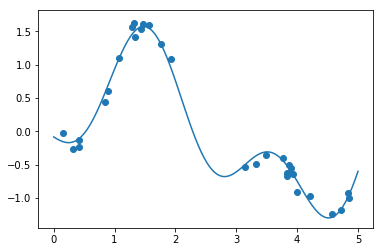

In [5]:
plt.plot(test_x, true_y.detach())
plt.scatter(train_x, train_y.detach())
plt.show()

## Some Prior Draws

In [6]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = Surrogate(test_x, true_y, lh, RBFKernel)

In [7]:
model.train()
lh.train();

n_samples = 4
samples = model(test_x).sample(sample_shape=torch.Size((n_samples,))).squeeze()


/home/vagrant/workspace/gpytorch/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


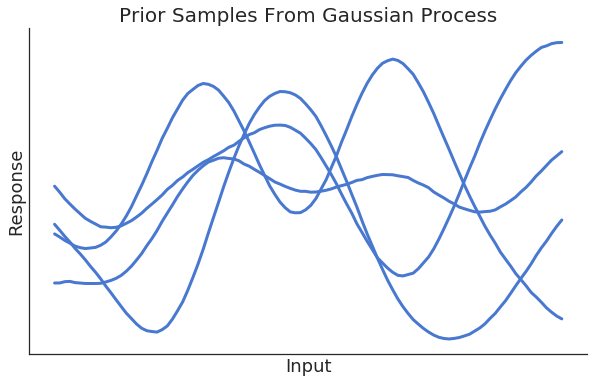

In [8]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
for smp in range(n_samples):
    plt.plot(test_x, samples[smp, :].detach(), color=colors[0],
            linewidth=lwd)

# plt.plot(train_x, train_y.detach(), marker="o", linestyle="None",
#         label="Observations", color=colors[1], markersize=5)
# plt.plot(test_x, pred_mean.detach(), label="Predicted Mean", color=colors[0],
#         linewidth=lwd)
# plt.fill_between(test_x, lower.detach(), upper.detach(),
#                 alpha=0.2)

plt.title("Prior Samples From Gaussian Process", fontsize=title_fs)
plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.legend( fontsize=leg_fs)
plt.show()

## Train and Get Posterior Samples

In [9]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = Surrogate(train_x, train_y, lh, RBFKernel)

In [10]:
model.train()
lh.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(lh, model)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    # print(loss.item())

In [11]:
model.eval()
lh.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [12]:
pred_dist = lh(model(test_x))
pred_mean = pred_dist.mean.detach()
lower, upper = pred_dist.confidence_region()

In [13]:
import seaborn as sns

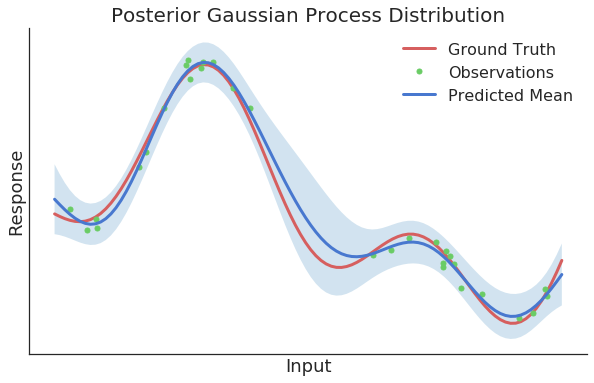

In [14]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
plt.plot(test_x, true_y.detach(), label="Ground Truth", color=colors[2],
        linewidth=lwd)
plt.plot(train_x, train_y.detach(), marker="o", linestyle="None",
        label="Observations", color=colors[1], markersize=5)
plt.plot(test_x, pred_mean.detach(), label="Predicted Mean", color=colors[0],
        linewidth=lwd)
plt.fill_between(test_x, lower.detach(), upper.detach(),
                alpha=0.2)

plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.title("Posterior Gaussian Process Distribution",
         fontsize=title_fs)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.legend(fontsize=leg_fs)
plt.show()

## Bayesian Optimization

In [33]:
train_x = torch.rand(5) * 5
train_y = true_func(train_x)

In [76]:
bayesopt = BayesOpt(train_x, train_y, normalize=False, normalize_y=False, max_x=5.)

In [35]:
# bayesopt.surrogate.train()
# bayesopt.surrogate_lh.train()

# optimizer = torch.optim.Adam(bayesopt.surrogate.parameters(), lr=0.01)
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(bayesopt.surrogate_lh,
#                                                bayesopt.surrogate)

# for i in range(200):
#     # Zero gradients from previous iteration
#     optimizer.zero_grad()
#     # Output from model
#     output = bayesopt.surrogate(bayesopt.train_x)
#     # Calc loss and backprop gradients
#     loss = -mll(output, bayesopt.train_y)
#     loss.backward()
#     optimizer.step()
#     print(loss.item())

In [36]:
bayesopt.train_surrogate(200)

train x =  tensor([0.8783, 1.9540, 4.4392, 3.8157, 3.4030])
train y =  tensor([ 0.5642,  0.8436, -1.1620, -0.6258, -0.2239])
Surrogate(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)
1.2268427610397339
1.2238295078277588
1.2208722829818726
1.2179701328277588
1.215118408203125
1.2123061418533325
1.2095164060592651
1.206731915473938
1.203940987586975
1.20114004611969
1.1983318328857422
1.195522427558899
1.1927181482315063
1.1899244785308838
1.1871448755264282
1.1843805313110352
1.1816307306289673
1.1788926124572754
1.1761630773544312
1.173439621925354
1.1707209348678589
1.168007493019104
1.165300965309143
1.1626036167144775
1.1599175930023193
1.1572450399398804
1.1545865535736084
1.151942253112793
1.14

In [37]:
bayesopt.surrogate

Surrogate(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [38]:
next_query = bayesopt.acquire()

In [39]:
bayesopt.surrogate.eval();
bayesopt.surrogate_lh.eval();

pred_dist = bayesopt.surrogate_lh(bayesopt.surrogate(test_x))
pred_mean = pred_dist.mean.detach()
lower, upper = pred_dist.confidence_region()

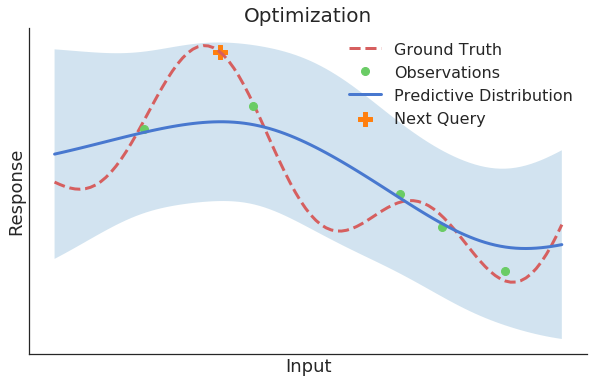

In [60]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
plt.plot(test_x, true_y.detach(), label="Ground Truth", color=colors[2],
        linewidth=lwd, linestyle="--")
plt.plot(train_x, train_y.detach(), marker="o", linestyle="None",
        label="Observations", color=colors[1], markersize=8)
plt.plot(test_x, pred_mean.detach(), label="Predictive Distribution", color=colors[0],
        linewidth=lwd)
plt.fill_between(test_x, lower.detach(), upper.detach(),
                alpha=0.2)

plt.scatter(next_query, true_func(next_query, 0.).detach(), marker="P", s=200,
           label="Next Query")

plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.title("Optimization",
         fontsize=title_fs)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.legend(fontsize=leg_fs)
plt.show()

In [77]:
bayesopt.update_obs(next_query.unsqueeze(0), true_func(next_query).unsqueeze(0))

before update: 
torch.Size([5, 1])
after update: 
torch.Size([6, 1])


In [78]:
bayesopt.train_surrogate(200);

train x =  tensor([0.8783, 1.9540, 4.4392, 3.8157, 3.4030, 1.6332])
train y =  tensor([ 0.5642,  0.8436, -1.1620, -0.6258, -0.2239,  1.5504])
Surrogate(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)
1.2767537832260132
1.2738124132156372
1.2709277868270874
1.268101692199707
1.2653357982635498
1.262630820274353
1.2599869966506958
1.2574046850204468
1.2548824548721313
1.252418875694275
1.2500112056732178
1.2476557493209839
1.2453478574752808
1.2430821657180786
1.240853190422058
1.238654613494873
1.2364808320999146
1.234326720237732
1.2321879863739014
1.230061650276184
1.227946162223816
1.22584068775177
1.2237458229064941
1.2216628789901733
1.21959388256073
1.217540979385376
1.215506672859192
1.21349346